In [1]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import dataset
import schedulers

import tensorflow as tf
assert tf.config.list_physical_devices('GPU')

In [61]:
BATCH_SIZE = 64

LETTERS_SIZE = len(dataset.letters_table)
NIQQUD_SIZE = len(dataset.niqqud_table)
DAGESH_SIZE = len(dataset.dagesh_table)
SIN_SIZE = len(dataset.sin_table)

def build_model(UNITS=380):  # EMBED_DIM=28
    inp = keras.Input(batch_shape=(None, None), batch_size=BATCH_SIZE)
    embed = layers.Embedding(LETTERS_SIZE, UNITS, mask_zero=True)(inp)
    
    layer = layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(embed)
    layer = layers.BatchNormalization()(layer)
    layer = layer + layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = embed + layers.Dense(UNITS, activation='relu')(layer)

    outputs = [
        layers.Softmax(name='N')(layers.Dense(NIQQUD_SIZE)(layer)),
        layers.Softmax(name='D')(layers.Dense(DAGESH_SIZE)(layer)),
        layers.Softmax(name='S')(layers.Dense(SIN_SIZE)(layer)),
    ]
    model = keras.Model(inputs=inp, outputs=outputs)

    return model

model = build_model()

model.summary()
model.save_weights('./checkpoints/uninit')

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, None, 380)    16720       input_19[0][0]                   
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, None, 380)    2313440     embedding_18[0][0]               
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, None, 380)    1520        bidirectional_21[0][0]           
___________________________________________________________________________________________

In [27]:

# masked version of accuracy and sce
def accuracy(real, pred):
    acc = tf.keras.metrics.sparse_categorical_accuracy(real, pred)

    mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)), dtype=acc.dtype)
    acc *= mask

    return tf.reduce_sum(acc) / tf.reduce_sum(mask)

def sparse_categorical_crossentropy(y_true, y_pred, sample_weight=None):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    mask = tf.cast(tf.math.logical_not(tf.math.equal(y_true, 0)), dtype=loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask) 

def fit(train_validation, scheduler=None, verbose=1, lr=1e-4, epochs=1):
    train, valid = train_validation
    model.compile(loss=sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics={'N': accuracy, 'D': accuracy, 'S': accuracy})
    callbacks = []
    if isinstance(scheduler, schedulers.CircularLearningRate):
        scheduler.set_dataset(train, BATCH_SIZE)
    if scheduler:
        callbacks.append(scheduler)
        
    x  = train.normalized
    vx = valid.normalized
    
    y  = {'N': train.niqqud, 'D': train.dagesh, 'S': train.sin }
    vy = {'N': valid.niqqud, 'D': valid.dagesh, 'S': valid.sin }
    
    return model.fit(x, y, validation_data=(vx, vy), batch_size=BATCH_SIZE, epochs=epochs, verbose=verbose, callbacks=callbacks)


MAXLEN = 64
def load_data(source, maxlen=MAXLEN, validation=0.1):
    filenames = [os.path.join('texts', f) for f in source]
    train, valid = dataset.load_data(filenames, validation, maxlen=maxlen)
    return train, valid

In [5]:
data_mix = load_data(['poetry', 'rabanit', 'pre_modern'])

In [58]:
model.load_weights('./checkpoints/uninit')
history = fit(data_mix, scheduler=schedulers.CircularLearningRate(30e-4, 80e-4, 1e-4), epochs=1)
model.save_weights('./checkpoints/mix')

2183/2183 [==============================] - 186s 85ms/step - loss: 0.2834 - N_loss: 0.2174 - D_loss: 0.0582 - S_loss: 0.0078 - N_accuracy: 0.9278 - D_accuracy: 0.9783 - S_accuracy: 0.9977 - val_loss: 0.2564 - val_N_loss: 0.1962 - val_D_loss: 0.0540 - val_S_loss: 0.0061 - val_N_accuracy: 0.9372 - val_D_accuracy: 0.9802 - val_S_accuracy: 0.9984


In [6]:
data_modern = load_data(validation=0.2, source=['modern'])

In [59]:
model.load_weights('./checkpoints/mix')
history = fit(data_modern, scheduler=schedulers.CircularLearningRate(50e-4, 60e-4, 1e-5))  #  EMBED_DIM=28, UNITS=253: val_N_accuracy: 0.9575 - val_D_accuracy: 0.9856 - val_S_accuracy: 0.9994
history = fit(data_modern, scheduler=schedulers.CircularLearningRate(1e-4, 6e-4, 1e-5), epochs=10)
model.save_weights('./checkpoints/modern')

233/233 [==============================] - 25s 106ms/step - loss: 0.1864 - N_loss: 0.1398 - D_loss: 0.0439 - S_loss: 0.0027 - N_accuracy: 0.9552 - D_accuracy: 0.9841 - S_accuracy: 0.9993 - val_loss: 0.1542 - val_N_loss: 0.1165 - val_D_loss: 0.0350 - val_S_loss: 0.0026 - val_N_accuracy: 0.9631 - val_D_accuracy: 0.9872 - val_S_accuracy: 0.9993
Epoch 1/10
233/233 [==============================] - 25s 107ms/step - loss: 0.0845 - N_loss: 0.0611 - D_loss: 0.0223 - S_loss: 0.0011 - N_accuracy: 0.9802 - D_accuracy: 0.9919 - S_accuracy: 0.9997 - val_loss: 0.1466 - val_N_loss: 0.1108 - val_D_loss: 0.0334 - val_S_loss: 0.0025 - val_N_accuracy: 0.9665 - val_D_accuracy: 0.9881 - val_S_accuracy: 0.9994
Epoch 2/10
233/233 [==============================] - 20s 86ms/step - loss: 0.0694 - N_loss: 0.0496 - D_loss: 0.0188 - S_loss: 9.2785e-04 - N_accuracy: 0.9837 - D_accuracy: 0.9931 - S_accuracy: 0.9997 - val_loss: 0.1465 - val_N_loss: 0.1111 - val_D_loss: 0.0330 - val_S_loss: 0.0025 - val_N_accuracy: 

In [32]:
model.load_weights('./checkpoints/modern_over')
history = fit(data_modern, scheduler=schedulers.CircularLearningRate(1e-4, 6e-4, 1e-5), epochs=3)
model.save_weights('./checkpoints/modern_over')

Epoch 1/3
466/466 [==============================] - 34s 72ms/step - loss: 0.0628 - N_loss: 0.0452 - D_loss: 0.0168 - S_loss: 8.3184e-04 - N_accuracy: 0.9844 - D_accuracy: 0.9937 - S_accuracy: 0.9998 - val_loss: 0.1631 - val_N_loss: 0.1237 - val_D_loss: 0.0366 - val_S_loss: 0.0028 - val_N_accuracy: 0.9677 - val_D_accuracy: 0.9890 - val_S_accuracy: 0.9994
Epoch 2/3
466/466 [==============================] - 29s 63ms/step - loss: 0.0598 - N_loss: 0.0429 - D_loss: 0.0161 - S_loss: 7.9951e-04 - N_accuracy: 0.9852 - D_accuracy: 0.9941 - S_accuracy: 0.9998 - val_loss: 0.1653 - val_N_loss: 0.1251 - val_D_loss: 0.0374 - val_S_loss: 0.0028 - val_N_accuracy: 0.9677 - val_D_accuracy: 0.9889 - val_S_accuracy: 0.9994
Epoch 3/3
466/466 [==============================] - 29s 63ms/step - loss: 0.0577 - N_loss: 0.0413 - D_loss: 0.0156 - S_loss: 7.8171e-04 - N_accuracy: 0.9856 - D_accuracy: 0.9942 - S_accuracy: 0.9998 - val_loss: 0.1664 - val_N_loss: 0.1265 - val_D_loss: 0.0371 - val_S_loss: 0.0028 - va

In [23]:
model.load_weights('./checkpoints/modern')
model.save('modern.h5')

In [24]:
import tensorflowjs as tfjs
# model.load_weights('./checkpoints/modern')
tfjs.converters.save_keras_model(model, '.')

C:\Users\elaza\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflowjs\converters\keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [15]:
model.load_weights('./checkpoints/modern')

def print_predictions(data, s):
    batch = data.normalized[s]
    prediction = model.predict(batch)
    [actual_niqqud, actual_dagesh, actual_sin] = [dataset.from_categorical(prediction[0]), dataset.from_categorical(prediction[1]), dataset.from_categorical(prediction[2])]
    [expected_niqqud, expected_dagesh, expected_sin] = [data.niqqud[s], data.dagesh[s], data.sin[s]]
    actual = dataset.merge(data.text[s], ts=batch, ns=actual_niqqud, ds=actual_dagesh, ss=actual_sin)
    expected = dataset.merge(data.text[s], ts=batch, ns=expected_niqqud, ds=expected_dagesh, ss=expected_sin)
    total = []
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        last = expected_niqqud[i].tolist().index(0)
        res = expected_niqqud[i][:last] == actual_niqqud[i][:last]
        total.extend(res)
        print(round(np.mean(res), 2), f'({last - sum(res)} out of {last})')
        print()
    print(round(np.mean(total), 3))

print_predictions(data_modern[1], slice(0, None))

מצוי:  דָּבָר לִרְגִיעָה בִּתְחוּם הַבִּיטָּחוֹן הַשּׁוֹטֵף. בְּמַהֲלָכָהּ יָזְמוּ הַפָלַסְטִינָאִים אַלְפֵי 
רצוי:  דָּבָר לִרְגִיעָה בִּתְחוּם הַבִּיטָּחוֹן הַשּׁוֹטֵף. בְּמַהֲלָכָהּ יָזְמוּ הַפָלַסְטִינָאִים אַלְפֵי 
1.0 (0 out of 60)

מצוי:  סֶקֶר שֶׁעָשְׁתָה חֶבְרַת yes, 20% מִצַרְכָנֵי עֲרוּצֵי הַפוֹרְנוֹגְרַפְיָה הֵם צַרְכָנִים 
רצוי:  סֶקֶר שֶׁעָשְׁתָה חֶבְרַת yes, 20% מִצַּרְכָנֵי עֲרוּצֵי הַפּוֹרְנוֹגְרַפְיָה הֵם צַרְכָנִים 
1.0 (0 out of 59)

מצוי:  אֵינָהּ הַגְדָּרָה בָּרַת יִישּׂוּם לְצוֹרֶךְ מַאֲמָר זֶה. בִּתְחִילַּת שְׁנוֹת הַ- 60 בִּלְבָלוֹ, 
רצוי:  אֵינָהּ הַגְדָּרָה בָּרַת יִישּׂוּם לְצוֹרֶךְ מַאֲמָר זֶה. בִּתְחִילַּת שְׁנוֹת הַ- 60 בִּלְבְּלוּ, 
0.97 (2 out of 61)

מצוי:  לַפַּרְכּוּסִים. כָּל הַבְּדִיקוֹת הָיוּ תַּקִּינוּת. כְּשֶׁהָרוֹפְאִים אָמְרוּ לָה שֶׁהֵם חוֹשְׁבִים 
רצוי:  לַפִּרְכּוּסִים. כָּל הַבְּדִיקוֹת הָיוּ תַּקִּינוֹת. כְּשֶׁהָרוֹפְאִים אָמְרוּ לָהּ שֶׁהֵם חוֹשְׁבִים 
0.97 (2 out of 62)

מצוי:  שֶׁלְּדַעְתּוֹ אֵינָם מְעַנְייְנִים מִבְּחִינַת הַמּוּרְכָּ

In [ ]:
for i in range(50):
    model.load_weights('./checkpoints/pre_modern')
    p1 = np.exp(np.random.uniform(low=np.log(1e-5), high=np.log(1e-2)))
    p2 = np.exp(np.random.uniform(low=np.log(1e-4), high=np.log(1e-1)))
    p3 = np.exp(np.random.uniform(low=np.log(1e-5), high=np.log(1e-2)))
    print(p1, p2, p3, end=', ', sep=', ')
    history = fit(data_modern, scheduler=schedulers.CircularLearningRate(p1, p2, p3), verbose=0)
    print(history.history['val_N_accuracy'][0])

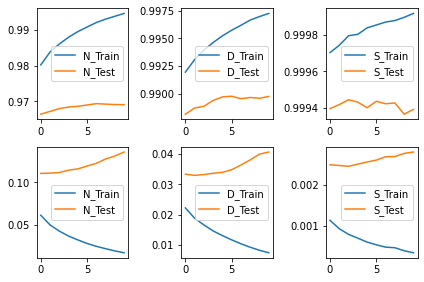

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=3)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['N', 'D', 'S'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [6]:
import hebrew
print(hebrew.ENDINGS_TO_REGULAR)

{'ך': 'כ', 'ם': 'מ', 'ן': 'נ', 'ף': 'פ', 'ץ': 'צ'}
